# Contents

This notebook gives and overview of the intial webscraping and Exploratory Data Analysis from The TimeOut website.

In [2]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from time import time, sleep
from bs4 import BeautifulSoup
import requests
import re

In [3]:
WINDOW_SIZE = "1920,1080"
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--window-size=%s" % WINDOW_SIZE)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

## Webscraping

Initial webscraping was from TimeOut's website.  This website indicated it had 16,000 restaurant listings (but as will be seen only 30% of these were available to be scraped for London).  
<br />
The overview page had an infinite rolling scroll with pause before each section of the page loaded.  This meant to scrape all the restaurant details needed would need the tools and libraries of selenium as well as the standard scraping tools of BeautifulSoup.

<br />
Once the initial list of restaurant information had been scraped, the details of the link to the detailed individual restaurant information page were needed to scrape the metadata information required.

In [6]:
#Example code used for scraping the raw list of restaurants from TimeOut and the link needed for detailed pages

headers = {'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

driver = webdriver.Chrome(executable_path=r'../web_scraping/selenium-examples/chromedriver',options=chrome_options)
driver.get('https://www.timeout.com/london/restaurants/search-restaurants')


'''
Scroll and open webpage using selenium with html read using BeautifulSoup after scrolling complete
'''
SCROLL_PAUSE_TIME = 3
# Get scroll height
last_height = driver.execute_script("return document.body.scrollHeight")
counta = 0 
while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    # Wait to load page
    sleep(SCROLL_PAUSE_TIME)
    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if (new_height == last_height) or (counta >=5): #This counta put limit on amount scrolling, but can leave out
        break
    last_height = new_height
    counta += 1
    print(counta)

soup = BeautifulSoup(driver.page_source, "html.parser")

'''
Information scraped from initial restaurant listing page
'''
to_title = []                 #List created for TimeOut restaurant title information
to_location = []              #List created for restaurant location
to_page_link = []             #List created for the page link to the detailed restaurant information - key for next stage
to_summary = []               #List created for the restaurant description summary on the front page

for item in soup.find_all('div', class_=re.compile('^xs-mb5*')):     #limit can be added
    try:
        to_title.append(item.find('h3', class_=re.compile('^xs-pt4*')).text.strip())
    except:
        to_title.append(np.nan)
    try:
        to_location.append(item.find('span', class_=re.compile('^xs-mr2*')).text.strip())
    except:
        to_location.append(np.nan)     
    try:
        to_page_link.append(item.find('a').attrs['href'])
    except:
        to_page_link.append(np.nan)
    try:
        to_summary.append(item.find('p', attrs={'class': 'xs-mb4 slab'}).text.strip())
    except:
        to_summary.append(np.nan)

df_timeout_list = pd.DataFrame({'to_title' : to_title, 'to_location' : to_location, 
                     'to_page_link': to_page_link, 'to_summary': to_summary})

In [12]:
#Check first 5 entries in the list
df_timeout_list.head()

,to_title,to_location,to_page_link,to_summary
0,IT Restaurant,Mayfair,/london/restaurants/it-restaurant,"The first UK outpost from the Ibiza-born fine dining restaurant, headed up by a two Michelin-starred chef."
1,Social Eating House,Soho,/london/restaurants/social-eating-house,"Under the gifted guidance of Paul Hood, one of Jason Atheron's talented team, imaginative modern cooking from a kitchen brigade at the top of its game."
2,Duck & Waffle,Liverpool Street,/london/restaurants/duck-waffle,"There’s a dedicated entrance for the restaurants in Heron Tower, from where a glass lift will whizz you in seconds up to Duck & Waffle on the 40th..."
3,Blanchette Shoreditch,Brick Lane,/london/restaurants/blanchette-shoreditch,A trendy-luxe French bistro on Brick Lane.
4,Hutong,Borough and London Bridge,/london/restaurants/hutong,"Like the original Hutong in Hong Kong, the Shard version is a glitzy place with amazing views, ersatz Old Beijing decor, and a Sichuan/Northern Chinese menu."


After obtaining this list, similar code was used to scrape the detailed metadata from the individual restaurant pages using the 'to_page_link' information combined with the general webpage link. On inspection the data was not consistently formatted so it was extracted in a relatively raw format to reduce data loss.  
<br />
The next step was to explore the data obtained to see how usable it was and to clean it up

## Initial Exploratory Data Analysis (EDA)

In [20]:
'''
Reload the data file from the detailed TimeOut webscraping
'''

df_timeout_raw = pd.read_csv('./data/timeout_raw_details.csv')
df_timeout_raw.head()

,title,cat1,cat2,location,t_rating,user_rating,t_reviewer,post_date,summary,lat_long,tube,address,price,website
0,IT Restaurant,Restaurants,Mediterranean,Mayfair,NaN,NaN,NaN,NaN,NaN,"https://www.google.com/maps/?q=51.509398,-0.142799",Tube: Green Park,\n 28-29 Dover Street \n London \n W1S 4LX \n,NaN,http://www.itrestaurants.com
1,Social Eating House,Restaurants,British,Soho,NaN,5 out of 5 stars\n\n\n\t\t (21user reviews),NaN,NaN,"Under the gifted guidance of Paul Hood, one of Jason Atheron's talented team, imaginative modern cooking from a kitchen brigade at the top of its game.","https://www.google.com/maps/?q=51.513811,-0.136682",Tube: Oxford Circus or Tottenham Court Road,\n 58-59 Poland Street \n London \n W1F 7NR \n,NaN,http://www.socialeatinghouse.com
2,Duck & Waffle,Restaurants,Contemporary European,Liverpool Street,NaN,4 out of 5 stars\n\n\n\t\t (79user reviews),NaN,NaN,NaN,"https://www.google.com/maps/?q=51.516282,-0.080964",Tube: Liverpool Street,\n Heron Tower \n 110 Bishopsgate \n London \n EC2N 4AY \n,NaN,https://duckandwaffle.com
3,Blanchette Shoreditch,Restaurants,Bistros,Brick Lane,4 out of 5 stars,5 out of 5 stars\n\n\n\t\t (26user reviews),Megan Carnegie Brown,NaN,A trendy-luxe French bistro on Brick Lane.,"https://www.google.com/maps/?q=51.524155,-0.071379",Shoreditch High Street Overground,\n 204 Brick Lane \n London \n E1 6SA \n,NaN,http://www.blanchettebricklane.co.uk
4,Hutong,Restaurants,Contemporary Asian,Borough and London Bridge,NaN,3 out of 5 stars\n\n\n\t\t (36user reviews),NaN,NaN,"Like the original Hutong in Hong Kong, the Shard version is a glitzy place with amazing views, ersatz Old Beijing decor, and a Sichuan/Northern Chinese menu.","https://www.google.com/maps/?q=51.504449,-0.086601",Tube/Rail: London Bridge,\n The Shard \n Level 33 \n 31 St. Thomas Street \n London \n SE1 9RY \n,4.0,http://www.aquahutong.co.uk


In [26]:
#Firstly let's explore what we have and its quality of the data
df_timeout_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4668 entries, 0 to 4667
Data columns (total 14 columns):
title          4654 non-null object
cat1           4654 non-null object
cat2           4401 non-null object
location       4652 non-null object
t_rating       1064 non-null object
user_rating    3916 non-null object
t_reviewer     1436 non-null object
post_date      4 non-null object
summary        1511 non-null object
lat_long       4648 non-null object
tube           3695 non-null object
address        4654 non-null object
price          1654 non-null float64
website        3669 non-null object
dtypes: float64(1), object(13)
memory usage: 510.7+ KB


There are 4668 entries but it would appear that none of the columns are complete. And we only have 1064 critic ratings for the restaurants.  Whilst this will reduce our final dataset for modelling significantly, after reviewing many different data sources this gives the largest number of critic ratings from one source.

In [23]:
#Let's look at the missing values a different way.  This will show the total missing values in each column
df_timeout_raw.isna().sum()

title          14  
cat1           14  
cat2           267 
location       16  
t_rating       3604
user_rating    752 
t_reviewer     3232
post_date      4664
summary        3157
lat_long       20  
tube           973 
address        14  
price          3014
website        999 
dtype: int64

Clearly some of the rows have just failed, but from examining the first five rows above and other exploration of the raw data then we can see that:
- Critic ratings (in the 't_rating' column) are integers between 1 and 5.  We can extract a numerical value for them.
- Average TimeOut user ratings (in the 'user_rating' column) are integers between 1 and 5.  We can extract the numerical value for them and also the number of user reviews submitted.
- We have enough information in the 'lat_long' column to extract the latitude and longitude of each restaurant - useful for future location feature creation
- We can extract the postcode from the 'address' column - potentially useful for future location feature location
- The descriptions in the 'Tube' column do not map consistently to individual tube stations, we will need to clean this up and find a method to gather the single closest tube station

### Cleaning

We'll create the following cleaned columns (as described above)by creating functions that use regex to extract the elements we want from the text:
- critic_rating_timeout
- user_rating_timeout
- users_timeout
- latitude
- longitude
- postcode
- tube

But first we'll drop duplicates and all null entries

In [27]:
df_timeout_raw.drop_duplicates(inplace=True)     #Drop duplicates
df_timeout_raw.dropna(how='all', inplace=True)   #Drop rows where all values are 'NaN'

In [30]:
'''
Function to extract rating from the rating text
'''
def rating(x):
    try:
        pattern=re.compile(r'^\d')
        return int(re.findall(pattern, x)[0])
    except:
        return np.nan

'''
Function to extract users from the user rating text
'''
def reviews_no(x):
    try:
        text = x.split('(')[-1]
        pattern=re.compile(r'\d+')
        return int(re.findall(pattern, text)[0])
    except:
        return np.nan

In [31]:
'''
Function to extract latitude from the lat_long text
'''
def lat_strip(x):
    try:
        pattern = re.compile(r'\d\d.\d+')
        return re.findall(pattern, x)[0]
    except:
        return np.nan

'''
Function to extract longitude from the lat_long text
'''
def long_strip(x):
    try:
        return x.split(',')[-1] 
    except:
        return np.nan

In [32]:
'''
Function to extract postcode from the address text
'''
def postcode_strip(x):
    try:
        return x.strip('\n').split('\n')[-1].strip(' ')
    except:
        return np.nan

In [33]:
'''
Function to extract tube stations from the tube text
'''
def tube_strip(x):
    try:
        return x.split(':')[-1].split('or ')[0].strip(' ').split('/')[0].split(',')[0]
    except:
        return np.nan

In [38]:
#Apply functions to the relevant columns
df_timeout_raw['critic_rating_timeout'] = df_timeout_raw.apply(lambda row: rating(row['t_rating']), axis=1)
df_timeout_raw['user_rating_timeout'] = df_timeout_raw.apply(lambda row: rating(row['user_rating']), axis=1)
df_timeout_raw['users_timeout'] = df_timeout_raw.apply(lambda row: reviews_no(row['user_rating']), axis=1)

df_timeout_raw['latitude'] = df_timeout_raw.apply(lambda row: lat_strip(row['lat_long']), axis=1)
df_timeout_raw['longitude'] =df_timeout_raw.apply(lambda row: long_strip(row['lat_long']), axis=1)

df_timeout_raw['postcode'] = df_timeout_raw.apply(lambda row: postcode_strip(row['address']), axis=1)
df_timeout_raw['tube'] = df_timeout_raw.apply(lambda row: tube_strip(row['tube']), axis=1)

In [113]:
df_timeout = df_timeout_raw.copy()
df_timeout.isnull().sum()

title                    0   
cat1                     0   
cat2                     253 
location                 2   
t_rating                 3217
user_rating              554 
t_reviewer               2866
post_date                4225
summary                  2805
lat_long                 6   
tube                     800 
address                  0   
price                    2655
website                  956 
critic_rating_timeout    3217
user_rating_timeout      554 
users_timeout            554 
latitude                 6   
longitude                6   
postcode                 0   
dtype: int64

There is an issue here where we appear to have a lot of nulls in many of the columns, especially the tube and price columns which will need resolving before modelling if we are to use them as features.

Next let's look at the distributions of the critic and user ratings using a histogram.

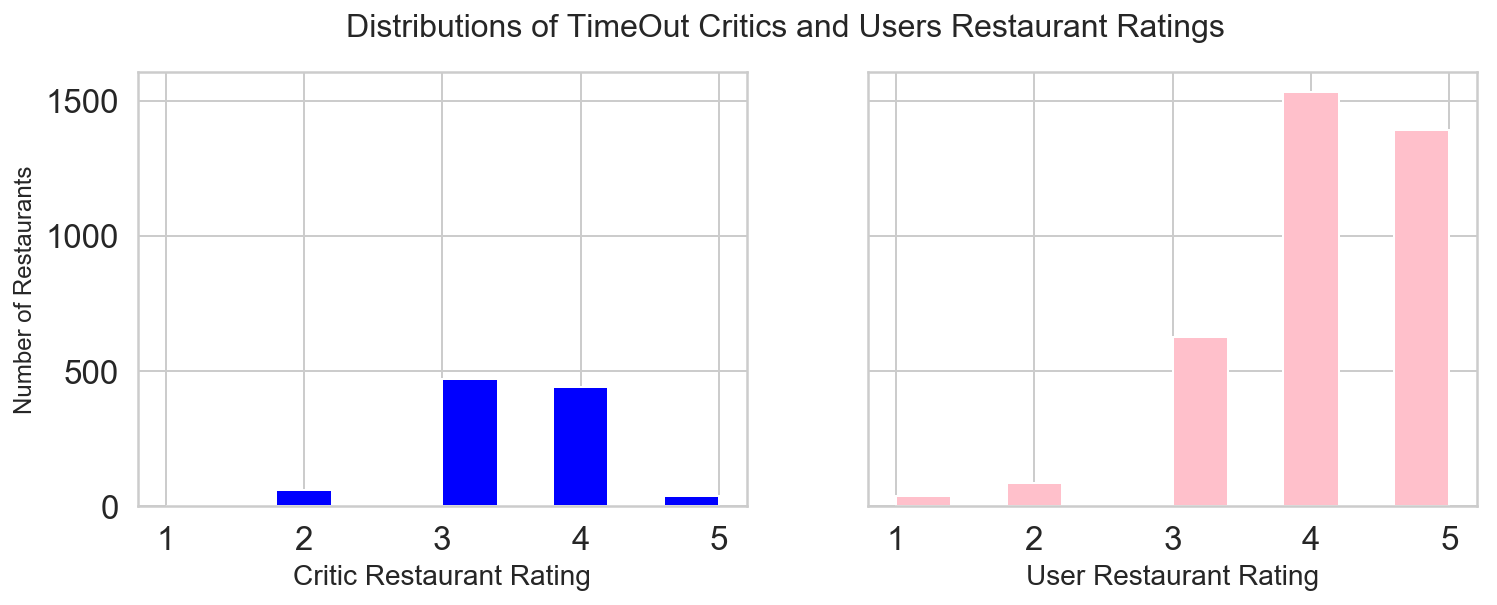

In [110]:
fig, ax=plt.subplots(ncols=2, figsize=(12,4), sharey=True)

plt.suptitle('Distributions of TimeOut Critics and Users Restaurant Ratings', fontsize=16)

ax[0].hist(df_timeout[~df_timeout['critic_rating_timeout'].isna()].critic_rating_timeout, 
           histtype='stepfilled', color='blue')
ax[0].set_xlabel('Critic Restaurant Rating', fontsize=14)
ax[0].set_ylabel('Number of Restaurants', fontsize=12)
ax[0].set_xticks(np.arange(1, 6, 1))

ax[1].hist(df_timeout[~df_timeout['user_rating_timeout'].isna()].user_rating_timeout,
           histtype='stepfilled', color='pink')
ax[1].set_xlabel('User Restaurant Rating', fontsize=14)
ax[1].set_xticks(np.arange(1, 6, 1))

plt.show();

These plots show that more restaurants had user ratings than a critic rating.  The critic rating distribution peaks at 3 (out of 5) and is only slightly skewed (i.e. it broadly follows a bell curve shape as a normal continous distribution would).  The user restaurant rating distribution is more negatively skewed with a peak at 4 (out of 5) and a long tail in the negative (or lower scores) direction.
<br /><br />
This is already interesting at how different the distributions are with a lower average score for the critic and a different spread of the distribution. A boxplot will show that more clearly:

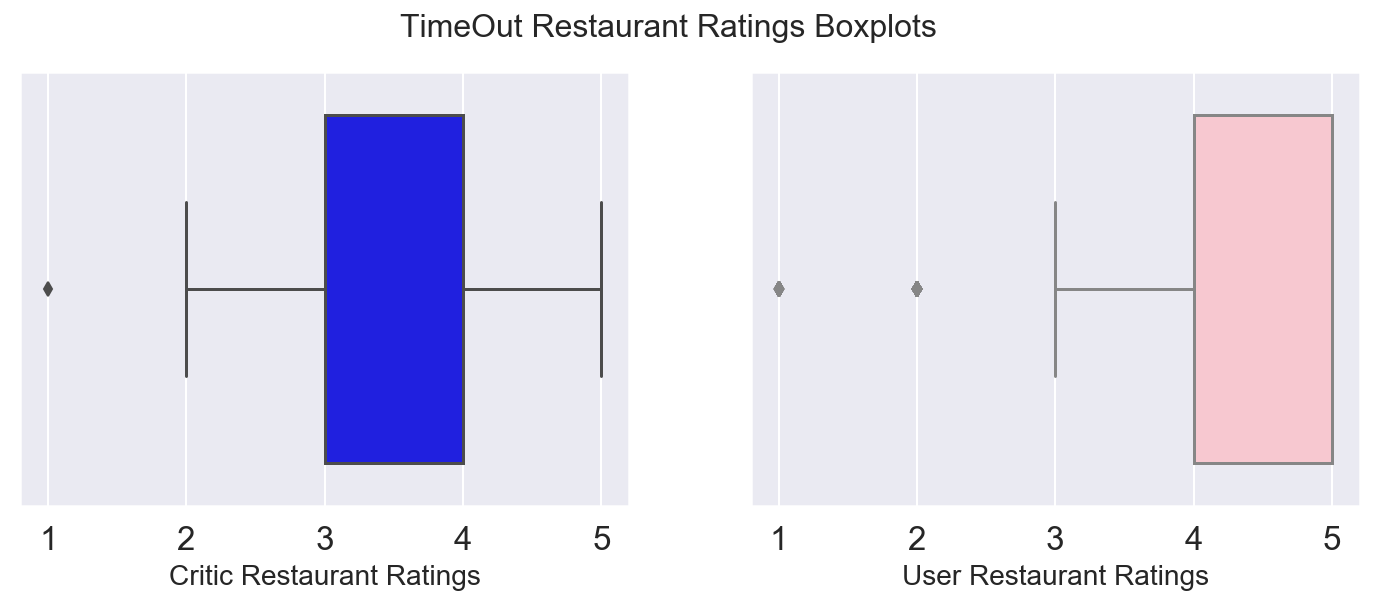

In [118]:
fig, ax=plt.subplots(ncols=2, figsize=(12,4), sharey=True)

plt.suptitle('TimeOut Restaurant Ratings Boxplots', fontsize=16)

sns.boxplot(df_timeout[~df_timeout['critic_rating_timeout'].isna()].critic_rating_timeout, ax=ax[0], color='blue')
sns.boxplot(df_timeout[~df_timeout['user_rating_timeout'].isna()].user_rating_timeout, ax=ax[1], color='pink')

ax[0].set_xlabel('Critic Restaurant Ratings', fontsize=14)
ax[1].set_xlabel('User Restaurant Ratings', fontsize=14)

plt.show()

This re-presents out what we could see from the histograms, the boxes show the quartiles or the centre of the data, ie where the ratings between the lower and upper quartile are.  The whiskers show where 1.5 standard deviations away from the centre comes to and the dots outside this are outliers.

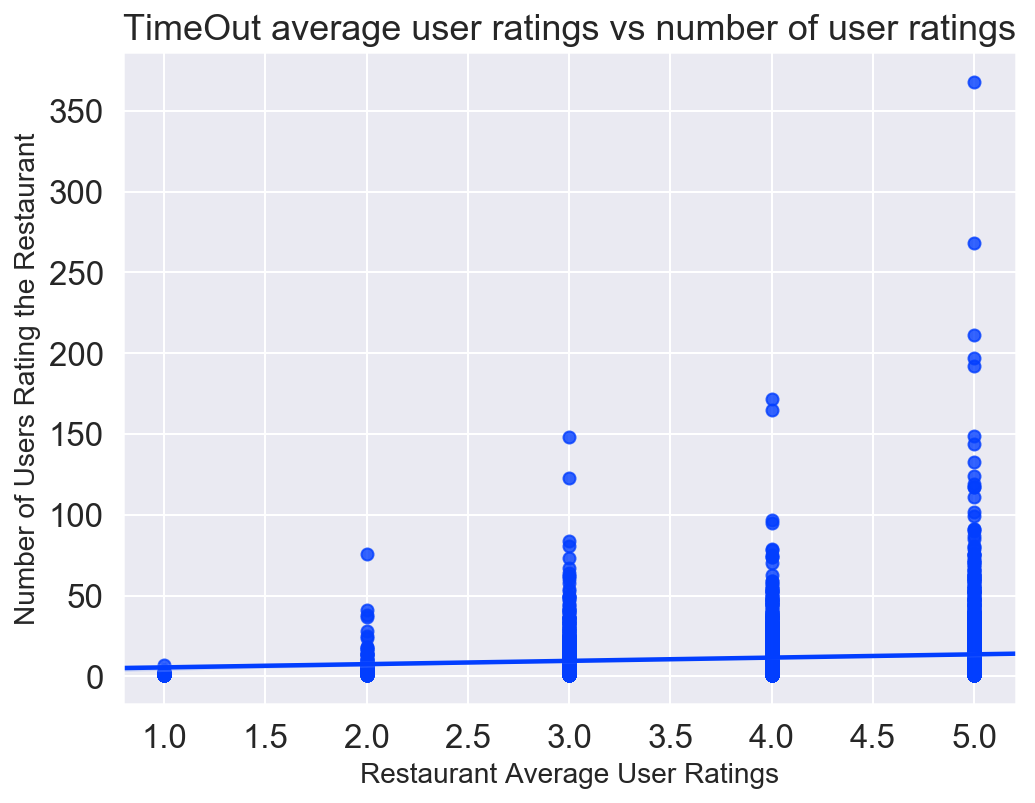

In [134]:
'''
Let's now look at the relationship between the number of user ratings and the average rating for a restaurant.
'''

sns.set_style("darkgrid")
sns.set_palette("bright")

fig, ax = plt.subplots(figsize=(8, 6))

#First we remove the null values using a filter
filter = (df_timeout.user_rating_timeout.isna()) | (df_timeout.users_timeout.isna())
df_user_ratings = df_timeout[~(filter)][['user_rating_timeout', 'users_timeout']]


sns.regplot(y=df_user_ratings.users_timeout, x=df_user_ratings.user_rating_timeout)

plt.title('TimeOut Average User Ratings vs Number of User Ratings')
ax.set_xlabel('Restaurant Average User Ratings', fontsize=14)
ax.set_ylabel('Number of Users Rating the Restaurant', fontsize=14)

plt.show();

This is interesting as it shows us that whilst the scatterplot element looks like a strong trend for the rating increasing with the number of users providing a rating, actually the average number of users providing a rating for each restaurant is quite small (as represented by the line on the plot).  This may be an issue for relying on these ratings (as they are not likely to be sufficiently large samples to be representative of the restaurant going population).

In [129]:
'''
Let's look at the average number of users for each user rating score
'''
df_timeout.groupby('user_rating_timeout').users_timeout.mean()

user_rating_timeout
1.0    1.657895 
2.0    7.977011 
3.0    10.677831
4.0    11.107120
5.0    13.867816
Name: users_timeout, dtype: float64

In [138]:
'''
This is small, let's see how many restaurant ratings are left 
if we omit restaurants with a low number of user ratings and
those which don't have a corresponding critic score
'''

five_ratings = df_timeout[df_timeout.users_timeout>=5]    # 5 used due to lowest level usually of value in statistical testing
thirty_ratings = df_timeout[df_timeout.users_timeout>=30] # 30 used due to Central Limit Theorem minimum level to generalise from a sample                          

df_critic_scores=df_timeout[~df_timeout['critic_rating_timeout'].isna()]

five_ratings_critic = df_critic_scores[df_critic_scores.users_timeout>=5]    
thirty_ratings_critic = df_critic_scores[df_critic_scores.users_timeout>=30]

print('The number of restaurants with at least 5 user ratings is', len(five_ratings), 
      'of which', len(five_ratings_critic), 'also have critic ratings')
print('The number of restaurants with at least 30 user ratings is', len(thirty_ratings),
      'of which', len(thirty_ratings_critic), 'also have critic ratings')

The number of restaurants with at least 5 user ratings is 2180 of which 630 also have critic ratings
The number of restaurants with at least 30 user ratings is 338 of which 82 also have critic ratings


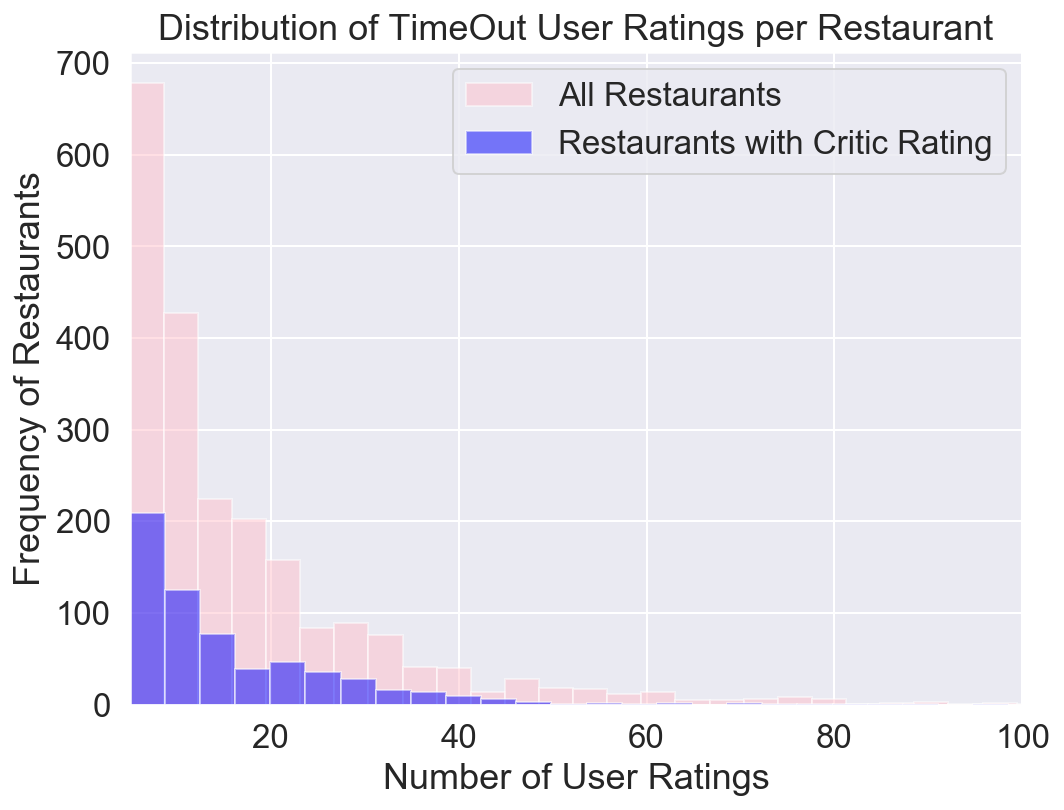

In [167]:
'''
Let's have a simple look at the distribution of the number of user ratings per restaurant using a histogram
We'll focus on the restaurants with at least 5 user ratings 
'''

fig, ax=plt.subplots(figsize=(8,6))

plt.title('Distribution of TimeOut User Ratings per Restaurant')

plt.hist(five_ratings.users_timeout, color='pink', bins=100, alpha=0.5, label='All Restaurants')
plt.hist(five_ratings_critic.users_timeout, color='blue', bins=50, alpha=0.5, label='Restaurants with Critic Rating')
plt.xlim(left=5, right=100)
ax.legend()
plt.xlabel('Number of User Ratings')
plt.ylabel('Frequency of Restaurants')

plt.show();

The TimeOut website is not as well used as expected.  Looking at other sites, there are larger number or user ratings for restaurants.  Google has more reviews per restaurant than here, and the data can be accessed through their search using metadata already gathered for each restaurant.  That data will be gathered next before further cleansing to resolve the missing values in key feature columns.

At this stage the target variable that we'll look to predict will be the difference between a restaurant's critic rating (representing an 'unbiased' rating) and its average user rating.  By creating and testing a range of location features alongside other features gathered from a restaurant's metadata to see their importance in predicting this differential, then we'll explore whether certain factors are indicating evidence of an environmental bias.

Features planned at this stage to be created are:
 - zone (created from location compared to nearest tube/ rail station data)
 - restaurant sparcity (created from number of restaurants in that area - from all restaurants)
 - restaurant category sparcity (created from number of that type of restaurant in that area - with cat2 reduced in number ie. to wider categories)
 - restaurant location by cluster (created by using clustering algorithms to group restaurants by density and location) - this will bring together sparcity and location
- distance from tourist sites

And the key general descriptive metadata to be used for features after cleaning are:
- restaurant category/ cuisine
- restaurant price/ budget range

As we don't have a large number of restaurants with critic ratings which limits our data set size, we will need to watch out for having high cardinality categorical features (i.e. too many different descriptors in a category) as these will challenge our model performance and its ability to generalise and pick out meaningful features.